# Look at different emission lines and calculate some ratios

First we load up the data as in the `01-extract-subregions` notebook:

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

Make a summed spectrum and an (H alpha + continuum) image

In [3]:
sp0 = cube.sum(axis=(1, 2))
im_ha = cube.select_lambda(6560.0, 6575.0).sum(axis=0)

And tell seaborn to make the graph labels more readable.

In [4]:
sns.set_context("talk")

## The density-sensitive  [S II] doublet at 6716, 6731 Å

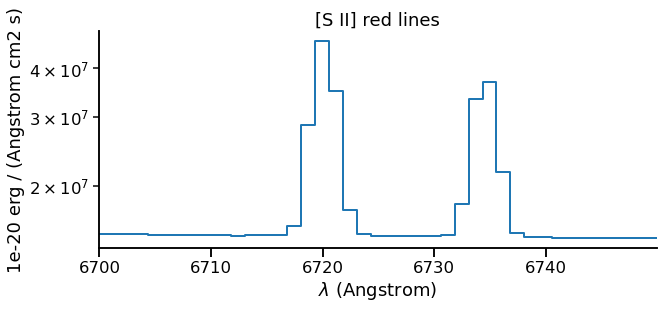

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6700.0, 6750.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S II] red lines",
)
sns.despine()

Find background continuum values.

In [6]:
im_c1 = cube.select_lambda(6710.0, 6715.0).mean(axis=0)
im_c2 = cube.select_lambda(6725.0, 6730.0).mean(axis=0)
im_c6716 = (im_c1 + im_c2) / 2.0
im_c3 = cube.select_lambda(6740.0, 6745.0).mean(axis=0)
im_c6731 = (im_c3 + im_c2) / 2.0

The following is a hack to try and resolve the negative intensity problem.  I subtract the minimum value (which is negative) from each map.  The reason that it is a hack is that we have no way of knowing if the minimum value *is* the true zero point of the data.  It seems to work OK for the [S II] lines, but less well for other lines, as we will see below.

In [7]:
im_c6716_00 = im_c6716.data.min()
im_c6731_00 = im_c6731.data.min()
im_sii16_00 = cube.select_lambda(6715.0, 6725.0).sum(axis=0).data.min()
im_sii31_00 = cube.select_lambda(6730.0, 6740.0).sum(axis=0).data.min()
im_c6716_00, im_c6731_00, im_sii16_00, im_sii31_00

(-40.987575721740725,
 -42.4315376251936,
 -1072.9333052635193,
 -724.2166128158569)

Subtract to isolate the two lines

In [8]:
im_sii16_bgsub = (cube.select_lambda(6715.0, 6725.0) - (im_c6716 - im_c6716_00)).sum(
    axis=0
) - im_sii16_00

im_sii31_bgsub = (cube.select_lambda(6730.0, 6740.0) - (im_c6731 - im_c6731_00)).sum(
    axis=0
) - im_sii31_00

Text(0.5, 1.0, '[S II] 6716 + 6731 brightness')

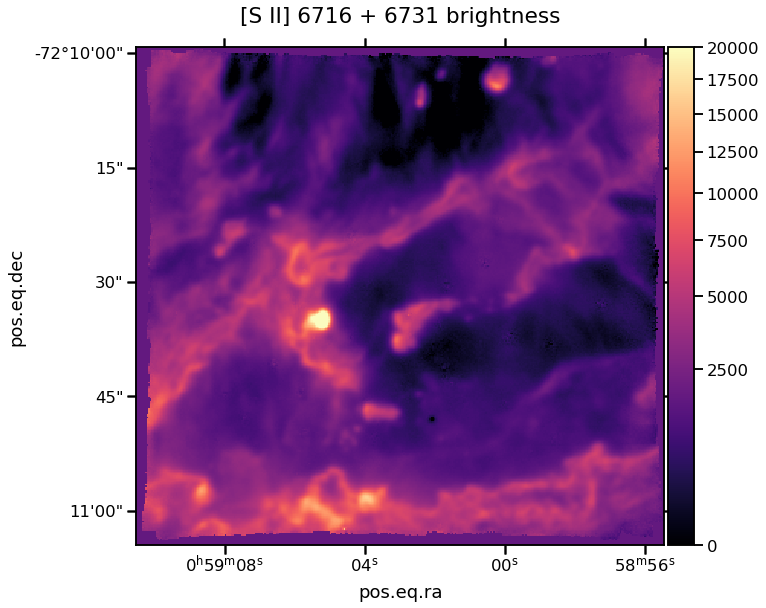

In [9]:
fig = plt.figure(figsize=(10, 10))
(im_sii16_bgsub + im_sii31_bgsub).plot(
    vmin=0.0,
    vmax=20000.0,
    use_wcs=True,
    cmap="magma",
    scale="sqrt",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[S II] 6716 + 6731 brightness",
    pad=25,
    fontsize="large",
)

### Correcting the zero point by matching the line ratio in the low-density limit

Drastic measures are called for to sort this out.  We will break out pandas and seaborn and plot some correlations:

In [10]:
import pandas as pd

In [11]:
sns.set_color_codes()

In [12]:
m = im_sii31_bgsub.data + im_sii16_bgsub.data < 20000.0
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6716": im_sii16_bgsub.data[m],
        "6731": im_sii31_bgsub.data[m],
    }
)

We have made a dataframe with two columns, one for 6716 and one for 6731.  We select only those up to a certain brightness, and eliminate the pixels around the border where there is no data.  Somehow, most of our images have lost their mask at this point, but `im_ha` still has it.  We have to remember that the mask is True when the data *are* masked, that is, bad.  Whereas I want a mask `m` for where the data are good, which is why I had to invert it: `~im_ha.mask`

Text(0.5, 0.98, 'Correlation between 6716 and 6731 brightness')

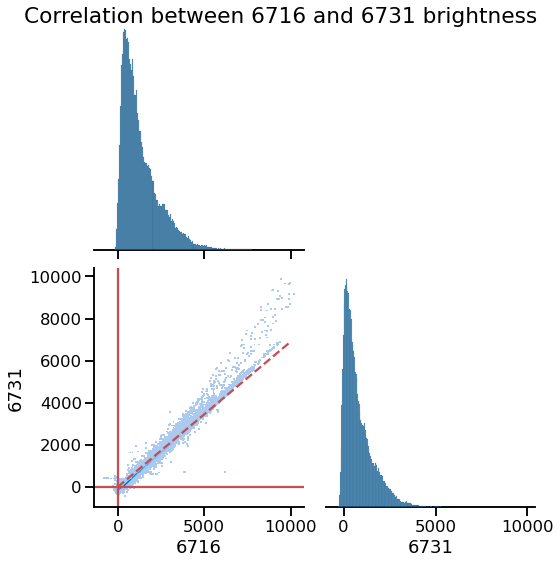

In [13]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, 1e4], [0, 1e4 / 1.45], "--", color="r")
g.fig.suptitle("Correlation between 6716 and 6731 brightness")

I am plotting a corner plot with the histograms of the two brightnesses plus the joint correlation.  We can see that the relation is closely linear at low brightness, but does not quite pass through the origin as it should.  And also, both histograms stray slightly onto the negative side.

Text(0.5, 0.98, 'Correction to 6716 and 6731 brightnesses')

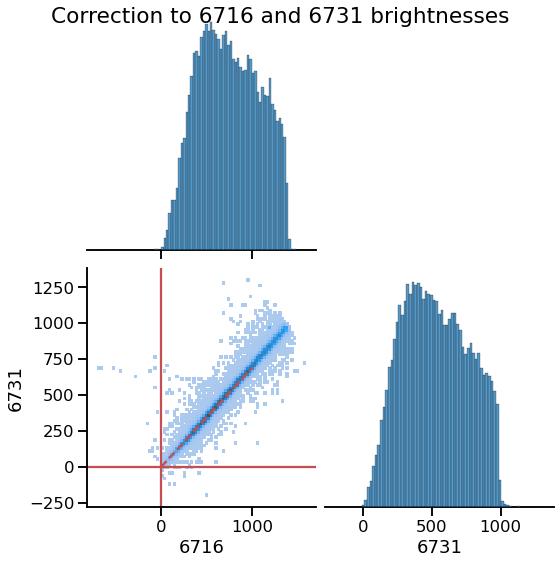

In [14]:
max_bright = 1000.0
m = im_sii31_bgsub.data + im_sii16_bgsub.data < 2 * max_bright
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6716": im_sii16_bgsub.data[m] + 120,
        "6731": im_sii31_bgsub.data[m] + 120 / 1.45 + 165,
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, max_bright], [0, max_bright / 1.45], "--", color="r")
g.fig.suptitle("Correction to 6716 and 6731 brightnesses")

In [15]:
im_sii16_bgsub += 120
im_sii31_bgsub += 120 / 1.45 + 165

Text(0.5, 1.0, '[S II] 6716 / 6731 ratio')

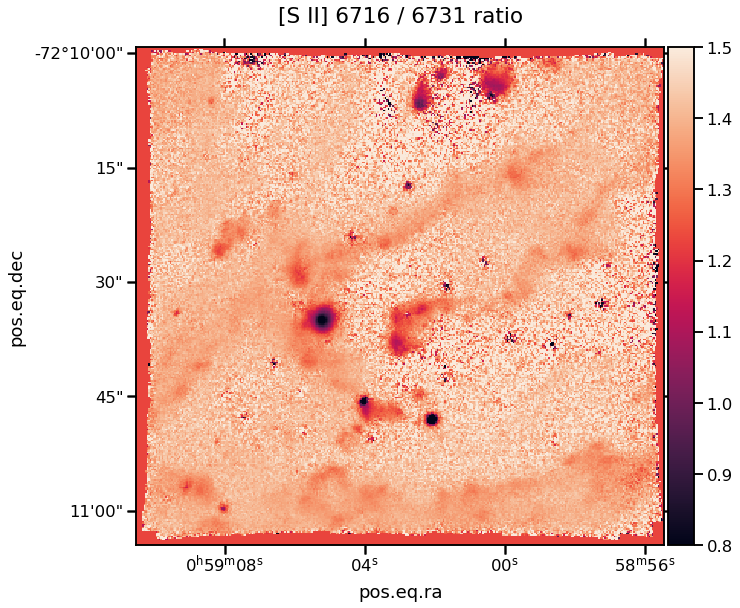

In [16]:
fig = plt.figure(figsize=(10, 10))
(im_sii16_bgsub / im_sii31_bgsub).plot(
    vmin=0.8,
    vmax=1.5,
    use_wcs=True,
    cmap="rocket",
    scale="linear",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[S II] 6716 / 6731 ratio",
    pad=25,
    fontsize="large",
)

So, there is quite a lot of apparent density variation.  The density seems to be positively correlated with surface brightness, which is to be expected on physical grounds.

We will now investigate that in detail via the histograms.

<ipython-input-17-af9c18dc1a40>:8: RuntimeWarning: invalid value encountered in log10
  "log10 6716": np.log10(im_sii16_bgsub.data[m]),
<ipython-input-17-af9c18dc1a40>:9: RuntimeWarning: invalid value encountered in log10
  "log10 6731": np.log10(im_sii31_bgsub.data[m]),


Text(0.5, 0.98, 'High end of 6716 and 6731 brightness distributions')

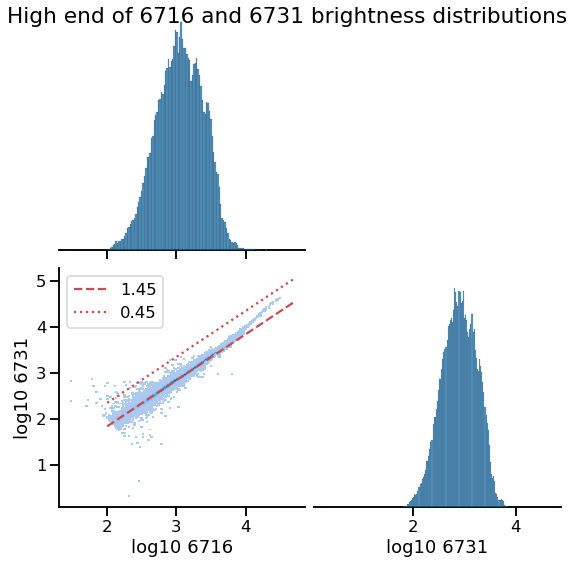

In [17]:
max_bright = 5e4
min_bright = 100.0
m = im_sii31_bgsub.data + im_sii16_bgsub.data < 2 * max_bright
m = m & (im_sii31_bgsub.data + im_sii16_bgsub.data > 2 * min_bright)
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "log10 6716": np.log10(im_sii16_bgsub.data[m]),
        "log10 6731": np.log10(im_sii31_bgsub.data[m]),
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].plot(
    np.log10([min_bright, max_bright]),
    np.log10([min_bright / 1.45, max_bright / 1.45]),
    "--",
    color="r",
    label="1.45",
)
g.axes[1, 0].plot(
    np.log10([min_bright, max_bright]),
    np.log10([min_bright / 0.45, max_bright / 0.45]),
    ":",
    color="r",
    label="0.45",
)
g.axes[1, 0].legend()
g.fig.suptitle("High end of 6716 and 6731 brightness distributions")

So, here we are looking at the bright end of the distributions on a logarithmic scale from 100 to 100,000 in summed brightness of 6716 and 6731.

The brightness distributions look approximately log-normal and the correlation is good across the whole range.  There is clear evidence of curving away from the low-density limit of the ratio at high brightness.  The low-density limit is plotted as the red dashed line and the high-density limit is the red dotted line.  The points never get anywhere near the high-density limit.

Text(0.5, 0.98, '[S II] 6716/6731 ratio versus summed brightness')

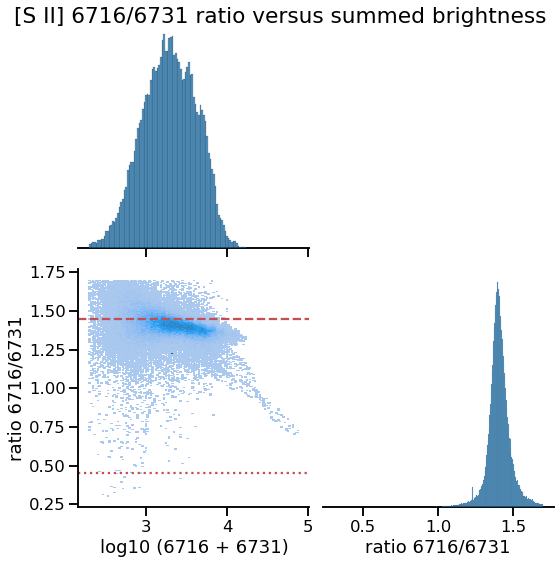

In [18]:
max_bright = 1e6
min_bright = 100.0
sum_sii = im_sii31_bgsub.data + im_sii16_bgsub.data
r_sii = im_sii16_bgsub.data / im_sii31_bgsub.data

m = sum_sii < 2 * max_bright
m = m & (sum_sii > 2 * min_bright)
m = m & ~im_ha.mask
m = m & np.isfinite(r_sii) & (r_sii > 0.3) & (r_sii < 1.7)

df = pd.DataFrame(
    {
        "log10 (6716 + 6731)": np.log10(sum_sii[m]),
        "ratio 6716/6731": r_sii[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axhline(1.45, ls="--", color="r")
g.axes[1, 0].axhline(0.45, ls=":", color="r")
g.fig.suptitle("[S II] 6716/6731 ratio versus summed brightness")

Now, we plot the joint distribution of the ratio and the sum.  This shows more clearly the reduction in ratio at high brightness.

[Text(0.5, 0, '[S II] ratio: 6716 / 6731'),
 Text(0, 0.5, 'CDF'),
 Text(0.5, 1.0, 'Cumulative $n_\\mathrm{e}$ distribution, partitioned by [S II] brightness')]

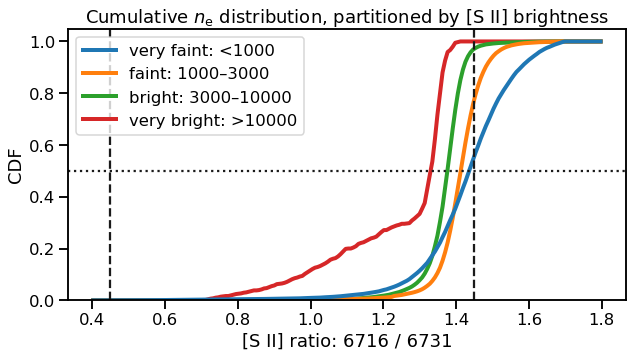

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

# Partition pixels into 4 groups according to brightness
mpart01 = sum_sii < 1000.0
mpart02 = (sum_sii >= 1000.0) & (sum_sii < 3000.0)
mpart03 = (sum_sii >= 3000.0) & (sum_sii < 10000.0)
mpart04 = sum_sii >= 10000.0

sns.histplot(
    {
        "very faint: <1000": r_sii[m & mpart01],
        "faint: 1000–3000": r_sii[m & mpart02],
        "bright: 3000–10000": r_sii[m & mpart03],
        "very bright: >10000": r_sii[m & mpart04],
    },
    cumulative=True,
    binrange=(0.4, 1.8),
    bins=200,
    stat="probability",
    common_norm=False,
    element="poly",
    fill=False,
    alpha=0.8,
    linewidth=4,
)
ax.axvline(0.45, ls="--", color="k")
ax.axvline(1.45, ls="--", color="k")
ax.axhline(0.5, ls=":", color="k")
ax.set(
    xlabel="[S II] ratio: 6716 / 6731",
    ylabel="CDF",
    title="Cumulative $n_\mathrm{e}$ distribution, partitioned by [S II] brightness",
)

Finally, we calculate the cumulative distribution of the ratios for four different brightness classes.

For the faintest partition (blue line), the noise is dominant, which is why the distribution is broad and encroaches into the forbidden region ($R > 1.45$ – the low-density and high-density limits are shown by vertical dashed lines).
The median value is a tiny bit less than 1.45, but it is very close to the low-density limit.

As we pass to the brighter and brighter partitions (orange, green, red lines), then the CDF moves to the left, corresponding to higher densities.

For the brightest partition (red line), the median value is about 1.3, which corresponds to a density of about 200 pcc. The orange line, on the other hand has a median of about 1.4, which is a density of about 30 pcc. *We should use pyneb to invert the ratio properly.*

It will be interesting to compare the distribution of $n$ with the distribution of brightness.

## [N II] lines

So, first, we can try and find the correction for [N II] 6548 and 6583.  They have the advantage that the ratio should be constant. 




In [21]:
im_blue_cont = cube.select_lambda(6540.0, 6545.0).mean(axis=0)
im_red_cont = cube.select_lambda(6555.0, 6560.0).mean(axis=0)
im_6548_cont = (im_blue_cont + im_red_cont) / 2.0
im_6548_bgsub = (cube.select_lambda(6545.0, 6555.0) 
                 - im_6548_cont).sum(axis=0)


im_blue_cont = cube.select_lambda(6575.0, 6580.0).mean(axis=0)
im_red_cont = cube.select_lambda(6590.0, 6595.0).mean(axis=0)
im_6583_cont = (im_blue_cont + im_red_cont) / 2.0
im_6583_bgsub = (cube.select_lambda(6580.0, 6590.0) 
                 - im_6548_cont).sum(axis=0)

Text(0.5, 1.0, '[N II] 6548 + 6583 brightness')

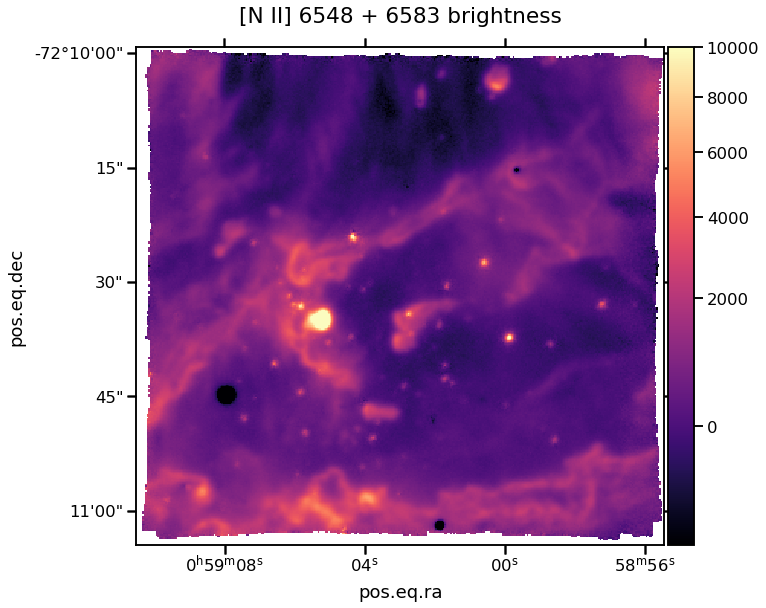

In [27]:
fig = plt.figure(figsize=(10, 10))
(im_6583_bgsub + im_6548_bgsub).plot(
    vmin=-600.0,
    vmax=10000.0,
    use_wcs=True,
    cmap="magma",
    scale="sqrt",
    colorbar="v",
)
fig.axes[0].set_title(
    label="[N II] 6548 + 6583 brightness",
    pad=25,
    fontsize="large",
)

Text(0.5, 0.98, 'Correlation between 6548 and 6583 brightness')

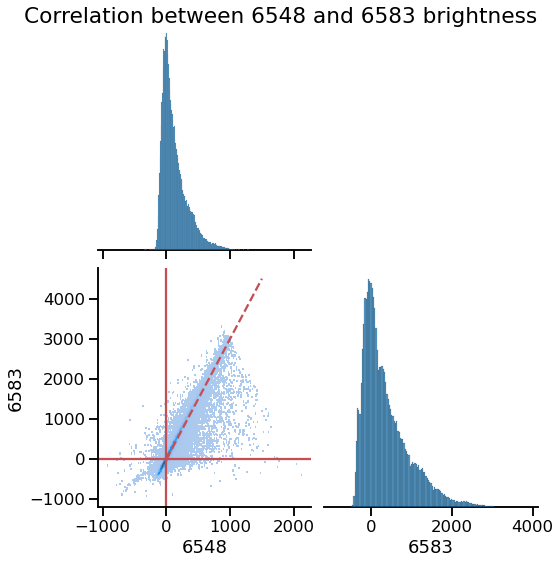

In [37]:
bright_max = 1500.0
nii_sum = 3*im_6548_bgsub.data + im_6583_bgsub.data
m = (nii_sum < 4*bright_max) & (nii_sum > -3000)
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6548": im_6548_bgsub.data[m],
        "6583": im_6583_bgsub.data[m],
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, bright_max], [0, bright_max*3], "--", color="r")
g.fig.suptitle("Correlation between 6548 and 6583 brightness")

Text(0.5, 0.98, 'Correction to 6548 and 6583 brightness')

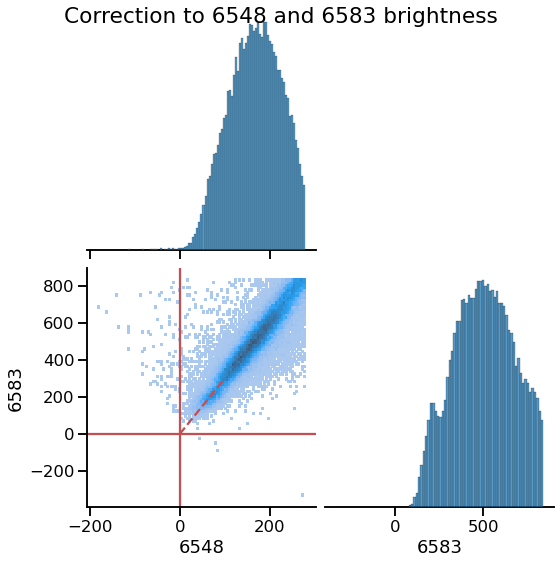

In [42]:
bright_max = 100.0
nii_sum = 3*im_6548_bgsub.data + im_6583_bgsub.data
m = (im_6583_bgsub.data < 3*bright_max) 
m = m & (im_6548_bgsub.data < bright_max) 
m = m & (nii_sum > -1000)
m = m & ~im_ha.mask
df = pd.DataFrame(
    {
        "6548": im_6548_bgsub.data[m] + 180,
        "6583": im_6583_bgsub.data[m] + 3*180,
    }
)

g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, bright_max], [0, bright_max*3], "--", color="r")
g.fig.suptitle("Correction to 6548 and 6583 brightness")

So this works, but it is not going anywhere.  I need to be able to fix it at the spectrum level.

In [44]:
cube.mask.shape

(3801, 326, 346)

In [58]:
m = np.array(im_6583_bgsub.data) < -3*180
m.sum(), m.sum() / np.product(m.shape)

(133, 0.001179119826944218)

In [60]:
mmm = np.repeat(m[None, :, :], cube.data.shape[0], axis=0).astype(float)
mmm.sum(), mmm.sum() / np.product(mmm.shape)

(505533.0, 0.001179119826944218)

In [61]:
sp_faint = np.average(cube.data, weights=mmm, axis=(1, 2))

In [64]:
sp1 = sp0.clone()

In [65]:
sp1.data = sp_faint
sp1.info()

[INFO] 3801 Spectrum (no name)
[INFO] .data(3801) (1e-20 erg / (Angstrom cm2 s)), no noise
[INFO] wavelength: min:4599.94 max:9349.94 step:1.25 Angstrom


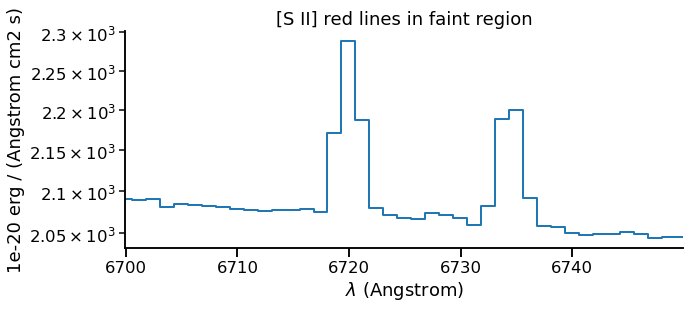

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
sp1.subspec(6700.0, 6750.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S II] red lines in faint region",
)
sns.despine()

In [67]:
cube.mask_selection?

## Other lines

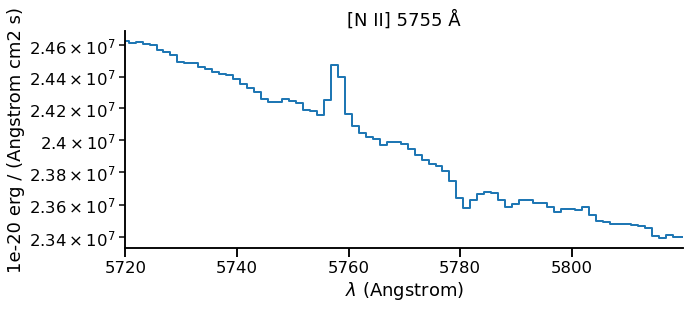

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(5720.0, 5820.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[N II] 5755 Å",
)
sns.despine()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(6270.0, 6390.0).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[O I] 6300,6363 Å and [S III] 6312 Å",
)
sns.despine()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
sp0.subspec(9050, 9100).plot(ax=ax, linewidth=2)
ax.set(
    yscale="log",
    title="[S III] 9069 Å",
)
sns.despine()

In [ ]:
im_c6312 = cube.select_lambda(6320.0, 6340.0).mean(axis=0)
im_c2 = cube.select_lambda(9065.0, 9070.0).mean(axis=0)
im_c3 = cube.select_lambda(9080.0, 9085.0).mean(axis=0)
im_c9069 = (im_c3 + im_c2) / 2.0

In [ ]:
im_siii6312_bgsub = (cube.select_lambda(6310.0, 6320.0) - im_c6312).sum(axis=0)
im_siii9069_bgsub = (cube.select_lambda(9070.0, 9080.0) - im_c9069).sum(axis=0)

In [ ]:
im_siii6312_bgsub += 150.0
im_siii9069_bgsub -= im_siii9069_bgsub.data.min()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
im_siii9069_bgsub.plot(
    vmin=0.0,
    vmax=10000.0,
    use_wcs=True,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
(im_siii6312_bgsub / im_siii9069_bgsub).plot(
    vmin=0.0,
    vmax=0.1,
    use_wcs=True,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)

In [ ]:
fig = plt.figure(figsize=(10, 10))
(im_siii9069_bgsub / im_sii31_bgsub).plot(
    vmin=0.0,
    vmax=12.0,
    use_wcs=True,
    cmap="gray_r",
    scale="linear",
    colorbar="v",
)
ax = fig.axes[0]
ax.set(
    title="[S III] 9069 / [S II] 6731",
)

In [ ]:
fig.axes